# **Lab 6 IMDB Sentiment Analysis**

Aim: 
- Use NN to predict sentiment of movie reviews
- Tune hyperparam to improve models

### **1. Import essential libraries**

In [90]:
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Flatten, Input, Activation
from keras.datasets import imdb
import keras.backend as K
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dropout
from keras.regularizers import l1, l2

import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer


### **2. Load, analyse data**

In [91]:
imdb_df = pd.read_csv("sample_data/IMDB_Dataset.csv",engine='python', encoding='utf-8', error_bad_lines=False)
imdb_df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [14]:
print(imdb_df.isnull().values.any())
print(imdb_df.shape)
print(imdb_df["review"][116])


False
(50000, 2)
Set in the 1794, the second year of the French republic formed after the execution of Louis XVI, this film portrays the power struggle between the revolutionary leaders Danton (Gerard Depardieu, at his finest) and Robespierre (a commanding performance by the Polish actor Wojciech Pszoniak). The moderate revolutionary Danton has returned to Paris from his country seat where he has been since being deposed as leader of the Committee of Public Safety in the previous year by Robespierre. He is opposed to "The Reign Of Terror" which has resulted in the executions of thousands of citizens, mainly by guillotine, who are thought to be opposed to the Revolution. Danton is confident of the support of the ordinary people and tries to persuade Robespierre to curb the bloodletting. But Robespierre and the Committee are afraid that the popularity of Danton will lead to them being overthrown, and put Danton and his supporters on trial for being traitors. This was the first French lan

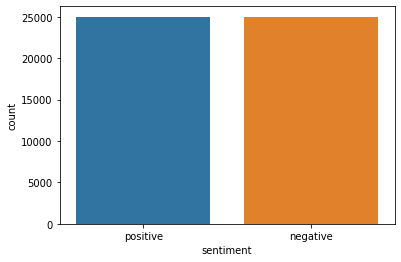

In [15]:
sns.countplot(x='sentiment', data=imdb_df)


### **3. Text Preprocessing**

Does the following to text
- Remove html tag
- Remove punctuation and number
- Remove Special Char
- Remove Stopwords
- Remove multiple spaces

In [17]:
# Run this whenever new runtime
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [92]:
stop_words = set(stopwords.words('english'))

def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    # Remove stopwords
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sen)
    filtered_sent = [i for i in tokens if not i in stop_words]
    filtered_sent= " ".join(filtered_sent)

    return filtered_sent

TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)





In [93]:
X = []
sentences = list(imdb_df['review'])
for sen in sentences:
    res = preprocess_text(sen)
    X.append(res)

y = imdb_df['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

print(X[116])
print(y[:10])

Set 1794 second year French republic formed execution Louis XVI film portrays power struggle revolutionary leaders Danton Gerard Depardieu finest Robespierre commanding performance Polish actor Wojciech Pszoniak The moderate revolutionary Danton returned Paris country seat since deposed leader Committee Public Safety previous year Robespierre He opposed The Reign Of Terror resulted executions thousands citizens mainly guillotine thought opposed Revolution Danton confident support ordinary people tries persuade Robespierre curb bloodletting But Robespierre Committee afraid popularity Danton lead overthrown put Danton supporters trial traitors This first French language film made Andrzej Wajda arrived France Poland His Polish film company closed government due support Solidarity trade union opposed Polish government late seventies early eighties His previous film Man Of Iron 1981 dealt Solidarity union leader Lech Walesa easy draw comparisons relationship Walesa Polish leader General Jar

In [45]:
print(X[116:118])


['Set 1794 second year French republic formed execution Louis XVI film portrays power struggle revolutionary leaders Danton Gerard Depardieu finest Robespierre commanding performance Polish actor Wojciech Pszoniak The moderate revolutionary Danton returned Paris country seat since deposed leader Committee Public Safety previous year Robespierre He opposed The Reign Of Terror resulted executions thousands citizens mainly guillotine thought opposed Revolution Danton confident support ordinary people tries persuade Robespierre curb bloodletting But Robespierre Committee afraid popularity Danton lead overthrown put Danton supporters trial traitors This first French language film made Andrzej Wajda arrived France Poland His Polish film company closed government due support Solidarity trade union opposed Polish government late seventies early eighties His previous film Man Of Iron 1981 dealt Solidarity union leader Lech Walesa easy draw comparisons relationship Walesa Polish leader General J

### **4. Divide Dataset into train, test**

Use sklearn train_test_split()

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### **5. Prepare Embedding Layer**

Embedding layer converts text data into numerical data
This embedding layer is used as 1st layer for NN (input layer)

1. Tokenizer is used to vectorise text (turn words into sequences)
*(=list of word indexes, where the word of rank i in the dataset (starting at 1) has index i).*
2. num_words param in Tokenizer means tokenization will only be done to the top n most common words in the dataset


In [95]:
max_features = 20000
maxlen = 100 # cut texts after this number of words (among top max_features most common words)
batch_size = 32
embedding_dim = 128

tokenizer = Tokenizer(num_words=5000) #top 5000 most common words vectorised
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
print('x_train shape:', X_train.shape)
print('x_test shape:', X_test.shape)

x_train shape: (35000, 100)
x_test shape: (15000, 100)


### **6. Build Model**

In [105]:
#MLP
print('Build model1...')
model = Sequential()
# Embedding(128, 1, embeddings_initializer='uniform',embeddings_regularizer=None, activity_regularizer=None, embeddings_constraint=None,mask_zero=False, input_length=None)
model.add(Embedding(max_features, 128,input_shape=(maxlen,),trainable=True))
model.add(Flatten())
model.add(Dense(128, activation='relu',activity_regularizer=l1(0.001)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu',activity_regularizer=l2(0.001)))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
from keras.utils import plot_model
plot_model(model, to_file='model.png')
es = EarlyStopping(monitor='val_loss', mode='min', patience=25)

Build model1...
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 100, 128)          2560000   
_________________________________________________________________
flatten_13 (Flatten)         (None, 12800)             0         
_________________________________________________________________
dense_29 (Dense)             (None, 128)               1638528   
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 129       
Total params: 4,215,169
Trainable params: 4,215,169
Non-trainable params: 0
___________________________

In [106]:
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print('Train...')
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=15, validation_split=0.25, callbacks=[es])
score, acc = model.evaluate(X_test, y_test,batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Epoch 1/15
821/821 [==============================] - 20s 24ms/step - loss: 0.3990 - accuracy: 0.8178 - val_loss: 0.3256 - val_accuracy: 0.8729
Epoch 2/15
821/821 [==============================] - 20s 24ms/step - loss: 0.1204 - accuracy: 0.9666 - val_loss: 0.4443 - val_accuracy: 0.8469
Epoch 3/15
821/821 [==============================] - 20s 24ms/step - loss: 0.0451 - accuracy: 0.9933 - val_loss: 0.5403 - val_accuracy: 0.8494
Epoch 4/15
821/821 [==============================] - 20s 24ms/step - loss: 0.0328 - accuracy: 0.9954 - val_loss: 0.5896 - val_accuracy: 0.8480
Epoch 5/15
821/821 [==============================] - 20s 25ms/step - loss: 0.0390 - accuracy: 0.9931 - val_loss: 0.7186 - val_accuracy: 0.8400
Epoch 6/15
821/821 [==============================] - 21s 25ms/step - loss: 0.0437 - accuracy: 0.9914 - val_loss: 0.6658 - val_accuracy: 0.8385
Epoch 7/15
821/821 [==============================] - 21s 25ms/step - loss: 0.0345 - accuracy: 0.9941 - val_loss: 0.6961 - val_

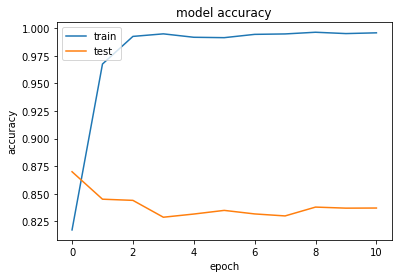

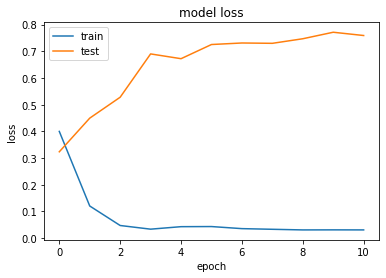

In [83]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

#Observe overfitting

In [101]:
#GloVe Embedding
vocab_size = len(tokenizer.word_index) + 1
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
#LSTM Attempt
from keras.layers.recurrent import LSTM

print('Build model2...')
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Flatten())
model.add(Dense(100, activation='relu',activity_regularizer=l2(0.001)))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

from keras.utils import plot_model
plot_model(model, to_file='model.png')
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

Build model2...
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 100, 100)          8787000   
_________________________________________________________________
dropout_8 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
flatten_14 (Flatten)         (None, 100)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 101       
Total params: 8,877,601
Trainable params: 90,601
Non-trainable params: 8,787,000
______________________

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print('Train...')
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=15, validation_split=0.25, callbacks=[es])
score, acc = model.evaluate(X_test, y_test,batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Epoch 1/15
821/821 [==============================] - 7s 8ms/step - loss: 0.6517 - accuracy: 0.6144 - val_loss: 0.5373 - val_accuracy: 0.7481
Epoch 2/15
821/821 [==============================] - 7s 8ms/step - loss: 0.6301 - accuracy: 0.6407 - val_loss: 0.6807 - val_accuracy: 0.5543
Epoch 3/15
821/821 [==============================] - 7s 8ms/step - loss: 0.5651 - accuracy: 0.7041 - val_loss: 0.4766 - val_accuracy: 0.7528
Epoch 4/15
821/821 [==============================] - 7s 8ms/step - loss: 0.4463 - accuracy: 0.7986 - val_loss: 0.3927 - val_accuracy: 0.8248
Epoch 5/15
821/821 [==============================] - 6s 8ms/step - loss: 0.4018 - accuracy: 0.8229 - val_loss: 0.3622 - val_accuracy: 0.8403
Epoch 6/15
821/821 [==============================] - 7s 8ms/step - loss: 0.3739 - accuracy: 0.8375 - val_loss: 0.3458 - val_accuracy: 0.8481
Epoch 7/15
821/821 [==============================] - 7s 8ms/step - loss: 0.3528 - accuracy: 0.8462 - val_loss: 0.3424 - val_accuracy: 0.84

In [110]:
#model 3 LSTM minus regularization
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
print(model.summary())
plot_model(model, to_file='model.png')
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 100, 100)          8787000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 129       
Total params: 8,904,377
Trainable params: 117,377
Non-trainable params: 8,787,000
_________________________________________________________________
None


In [111]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print('Train...')
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=15, validation_split=0.25, callbacks=[es])
score, acc = model.evaluate(X_test, y_test,batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Epoch 1/15
821/821 [==============================] - 7s 8ms/step - loss: 0.5587 - accuracy: 0.7134 - val_loss: 0.4508 - val_accuracy: 0.7959
Epoch 2/15
821/821 [==============================] - 6s 8ms/step - loss: 0.4349 - accuracy: 0.8048 - val_loss: 0.4177 - val_accuracy: 0.8219
Epoch 3/15
821/821 [==============================] - 7s 8ms/step - loss: 0.3779 - accuracy: 0.8361 - val_loss: 0.4028 - val_accuracy: 0.8193
Epoch 4/15
821/821 [==============================] - 7s 8ms/step - loss: 0.3369 - accuracy: 0.8549 - val_loss: 0.3350 - val_accuracy: 0.8491
Epoch 5/15
821/821 [==============================] - 7s 8ms/step - loss: 0.3137 - accuracy: 0.8672 - val_loss: 0.3313 - val_accuracy: 0.8565
Epoch 6/15
821/821 [==============================] - 7s 8ms/step - loss: 0.2891 - accuracy: 0.8791 - val_loss: 0.3187 - val_accuracy: 0.8610
Epoch 7/15
821/821 [==============================] - 7s 8ms/step - loss: 0.2607 - accuracy: 0.8943 - val_loss: 0.3379 - val_accuracy: 0.86